# A prototype of a function that will generate FRB data on the fly

In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan


In [3]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2")

parsing values --ndm 2


In [4]:
dir(plan)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'baseline_order',
 'baseline_shape',
 'baselines',
 'boxcar_weight',
 'dmax',
 'dtype',
 'fdmt_plan',
 'fdmt_scale',
 'fft_scale',
 'fft_ssr',
 'fmax',
 'fmin',
 'foff',
 'freqs',
 'get_uv',
 'lower_idxs',
 'lower_instructions',
 'lower_shifts',
 'nbl',
 'nbox',
 'nchunk_time',
 'ncin',
 'ncu',
 'nd',
 'ndout',
 'nf',
 'ngridreg',
 'npix',
 'nt',
 'nuvmax',
 'nuvrest',
 'nuvrest_max',
 'nuvwide',
 'save_fdmt_plan_lut',
 'save_grid_instructions',
 'save_lut',
 'save_pad_lut',
 'threshold',
 'upper_idxs',
 'upper_instructions',
 'upper_shifts',
 'uv_shape',
 'uvcells',
 'values']

In [5]:
# IN the plan are a few useful thing. e.g.
plan.nt # samples per block

256

In [7]:
plan.nbl # Number of baselines in the FITS file

190

In [8]:
plan.nf # number of frequencies

256

In [9]:
!ls /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/

allvars.txt
askap-ak1-ak20.ant
frb_d0_t0_a1_sninf_lm00.fits
frb_d0_t0_a1_sninf_lm00.fits.doshift.lower.txt
frb_d0_t0_a1_sninf_lm00.fits.doshift.upper.txt
frb_d0_t0_a1_sninf_lm00.fits.frbpos
frb_d0_t0_a1_sninf_lm00.fits.gridlut.lower.txt
frb_d0_t0_a1_sninf_lm00.fits.gridlut.upper.txt
frb_d0_t0_a1_sninf_lm00.fits.mir
frb_d0_t0_a1_sninf_lm00.fits.ndm4_nt16.b0.uvdata.raw
frb_d0_t0_a1_sninf_lm00.fits.ndm4_nt16.b0.uvdata.raw.cand
frb_d0_t0_a1_sninf_lm00.fits.ndm4_nt16.b0.uvdata.raw.grid.dat
frb_d0_t0_a1_sninf_lm00.fits.ndm4_nt16.b0.uvdata.raw.img.dat
frb_d0_t0_a1_sninf_lm00.fits.ndm4_nt16.b1.uvdata.raw
frb_d0_t0_a1_sninf_lm00.fits.padlut.lower.txt
frb_d0_t0_a1_sninf_lm00.fits.padlut.upper.txt
frb_d0_t0_a1_sninf_lm00.fits.uvgrid.split.txt
frb_d0_t0_a1_sninf_lm00.fits.uvgrid.txt
params.env
params.txt
varchanges.txt


In [11]:
!wc -l /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/askap-ak1-ak20.ant

20 /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/askap-ak1-ak20.ant


In [12]:
!cat /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/askap-ak1-ak20.ant

20.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00
-2.150329636968672276e+01 -1.173552514985203743e+01 -1.727016607951372862e+01
-3.343353211972862482e+01 6.861585719976574183e+00 -1.361964868009090424e+01
1.081218420062214136e+00 3.153198138996958733e+01 1.761779008992016315e+01
5.986812921008095145e+01 2.856493587000295520e+01 4.549570676032453775e+01
-1.431919342200271785e+02 1.007761074802838266e+02 -1.795608146954327822e+01
-1.943144536796025932e+02 -9.857980239996686578e+01 -1.538451231392100453e+02
8.219105618027970195e+01 -2.133678917698562145e+02 -7.800406320951879025e+01
1.957080640201456845e+02 9.946505727013573050e+01 1.540394347999244928e+02
3.023099467018619180e+01 2.513872916400432587e+02 1.528519401308149099e+02
-3.075637542298063636e+02 3.052556829601526260e+02 1.310697656031697989e+01
-4.077545295096933842e+02 2.410670941499993205e+02 -7.226584170944988728e+01
-3.188500306396745145e+02 -3.276292930399067700e+02 -3.409893426597118378e+02
1.1569

In [14]:
plan.baseline_shape # shape of the input data - (nbl, nf, nt)

(190, 256, 256)

In [18]:
plan.fmin # Bottom frequency in Hz - retrieved from fits file - but how it go thtere, I dont' know
# Looks like center of the bottom channel

735499993.944

In [17]:
plan.fmax # top frequency in Hz

990500006.0565

In [63]:
class Myvalues:
    pass

values = Myvalues
values.nfrbs = 3
values.ndmax = 1024 # longest FRB that you might simulate = shortest interval between simulated FRBs

def generate_data(plan, values):
    nt = plan.nt
    frb_shape = (plan.nbl, plan.nf, values.ndmax)
    yaml_file = values.test_yaml
    config = load(yaml_file)
        
    
    assert values.ndmax % nt == 0, 'Largest FRB must be a multiple of NT'
    for ifrb in range(values.nfrbs): # we will generate this many FRBs
        # FRB generate FRB - it must be is 1 or more blocks of NT samples
        frb = np.zeros(frb_shape, dtype=np.complex64)
        frb.real = np.random.randn(*frb_shape)
        frb.imag = np.random.randn(*frb_shape)
        #frb.real.flat = np.arange(np.prod(frb.shape))
        # point source at the phase center
        # DM = 0, time=3
        for t0 in (6, 8, 123, 245):
            chanamp = 7
            frb[:, :, t0].real += chanamp
                        
        for tblk in range(values.ndmax // nt):
            cutout = frb[:,:,nt*tblk:nt*(tblk+1)]            
            assert cutout.shape == plan.baseline_shape, f'It was {cutout.shape}!={plan.baseline_shape}'
            yield cutout
        
        

In [64]:
g = generate_data(plan, values)

6947.6025
-400.8559


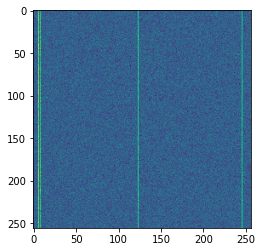

In [65]:
img = next(g)[0,:,:]
print(img.real.sum())
print(img.imag.sum())
imshow(img.real)